In [1]:
#sys
import random
import os
import copy
import sys
from collections import Counter
import gc
import time

#torch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
from torchvision import get_image_backend

#other
import numpy as np
import pandas as pd
import colorcet as cc
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

#customized
from preprocess import P1_TransformsModelB, P1TestDataset
from utils import P1Args, train, valid, save_checkpoint, do_avg_on_list

/home/guest/r11922a05/anaconda3/envs/DLCV2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_PATH = 'p1_model.pth'
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

In [3]:
NUM_CLASS = 50
model = models.resnet152()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASS)

state_dict = torch.load(MODEL_PATH)
model.load_state_dict(
    state_dict['model']
)

<All keys matched successfully>

In [7]:
def get_label(img_files):
    labels = []
    for img_name in img_files:
        file_name = img_name.split("_")
        label = file_name[0]
        labels.append(int(label))
    return labels

In [13]:
VAL_PATH = 'hw1_data/p1_data/val/'
data_transforms = P1_TransformsModelB()
val_dataset = datasets.ImageFolder(
        root=VAL_PATH,
        transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)
val_loader = DataLoader(
    val_dataset, batch_size=2, 
    shuffle=False, num_workers=8
)   

model = model.to(device)
model.eval()
with torch.no_grad():
    valid_acc = []
    for img, label in val_loader:
        img, label = img.to(device), label.to(device)
        output = model(img)
        predict = torch.argmax(output, dim=-1)
        if label[0] == 3 and label[1] == 3:
            #print(img.size()) #(3, 224, 224)
            print(img[1, :10, :10], label)
            print(predict)
            break
        acc = (label == predict).cpu().tolist()
        valid_acc += acc
valid_acc = np.mean(valid_acc)

###double check####
print(valid_acc)

tensor([[[0.4157, 0.3882, 0.4431, 0.2706, 0.2745, 0.4353, 0.4118, 0.3804,
          0.4039, 0.2314, 0.2196, 0.1137, 0.1686, 0.1569, 0.0118, 0.0118,
          0.0706, 0.0235, 0.0039, 0.0039, 0.0000, 0.0039, 0.0039, 0.0039,
          0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
         [0.3529, 0.3373, 0.3098, 0.2549, 0.2196, 0.2627, 0.2980, 0.3098,
          0.2941, 0.1843, 0.1255, 0.0745, 0.2000, 0.2863, 0.1176, 0.0196,
          0.1059, 0.0314, 0.0000, 0.0039, 0.0039, 0.0000, 0.0039, 0.0039,
          0.0078, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
         [0.4902, 0.5412, 0.5176, 0.5294, 0.4941, 0.5020, 0.5765, 0.5922,
          0.5412, 0.3333, 0.0000, 0.0157, 0.2549, 0.3569, 0.2824, 0.0627,
          0.1373, 0.0824, 0.0118, 0.0196, 0.1020, 0.2980, 0.1020, 0.0000,
          0.0118, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
         [0.3529, 0.3961, 0.4235, 0.3961, 0.4196, 0.4863, 0.5059, 0.5059,
          0.5765, 0.4510, 0.1333, 0

In [20]:
IMG_PATH = 'test_dir'
imgs_path = os.listdir(IMG_PATH)
imgs_path = sorted(imgs_path)
label = get_label(imgs_path)

In [21]:
val_dataset = P1TestDataset(
    imgs_path,
    label,
    transforms.Compose(
        [transforms.ToTensor()]
    )
    )

val_loader = DataLoader(
    val_dataset, batch_size=2, 
    shuffle=False, num_workers=8
)   

model = model.to(device)
model.eval()
with torch.no_grad():
    valid_acc = []
    for path, img, label in val_loader:
        img, label = img.to(device), label.to(device)
        if label[0] == 3 and label[1] == 3:
            #print(img.size()) #(3, 224, 224)
            print(img[1, :10, :10], label)
            print(predict)
            break
        output = model(img)
        predict = torch.argmax(output, dim=-1)
        acc = (label == predict).cpu().tolist()
        valid_acc += acc
valid_acc = np.mean(valid_acc)

###double check####
print(valid_acc)

tensor([[[0.7059, 0.7176, 0.7255, 0.7294, 0.7294, 0.7294, 0.7333, 0.7333,
          0.7373, 0.7412, 0.7412, 0.7412, 0.7451, 0.7922, 0.8353, 0.7412,
          0.7373, 0.7216, 0.7373, 0.7961, 0.7922, 0.7843, 0.7529, 0.7255,
          0.7216, 0.6314, 0.6275, 0.6118, 0.5961, 0.5686, 0.5412, 0.5176],
         [0.7176, 0.7216, 0.7216, 0.7098, 0.7059, 0.7059, 0.7059, 0.7255,
          0.7333, 0.7333, 0.7333, 0.7373, 0.7608, 0.8353, 0.7176, 0.6706,
          0.6667, 0.6588, 0.5765, 0.6196, 0.6235, 0.5961, 0.5529, 0.5373,
          0.5294, 0.4471, 0.4235, 0.4078, 0.4000, 0.3843, 0.3608, 0.3569],
         [0.7098, 0.7059, 0.7020, 0.6980, 0.6941, 0.6941, 0.6980, 0.7216,
          0.7333, 0.7333, 0.7373, 0.7569, 0.8275, 0.7765, 0.6471, 0.6471,
          0.6235, 0.5843, 0.5255, 0.5765, 0.5843, 0.5843, 0.5843, 0.5451,
          0.5843, 0.6078, 0.6196, 0.6078, 0.6235, 0.6275, 0.5725, 0.5922],
         [0.6941, 0.6902, 0.6902, 0.6941, 0.6902, 0.6941, 0.6941, 0.7176,
          0.7333, 0.7373, 0.7412, 0

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [7]:
model.fc = Identity()

In [8]:
model.eval()
labels = []
isFirstMiniBatch = True
with torch.no_grad():
    for img, label in val_loader:
        img, label = img.to(device), label.to(device)
        output = model(img)
        output = output.detach().cpu().numpy()
        if isFirstMiniBatch:
            out = output
            isFirstMiniBatch = False
        else:
            out = np.concatenate(
                [out, output], axis=0
            )
        labels.extend(label.detach().cpu().numpy())

### PCA

In [49]:
pca = PCA(n_components=2)
pca.fit(out)
principalComponents = pca.fit_transform(out)
principalDf = pd.DataFrame(
    data = principalComponents, 
    columns = ['principal component 1', 'principal component 2']
    )
df_label = pd.DataFrame(
    labels, columns=['class']
)
finalDf = pd.concat([principalDf, df_label[['class']]], axis = 1)

Text(0, 0.5, 'PC2')

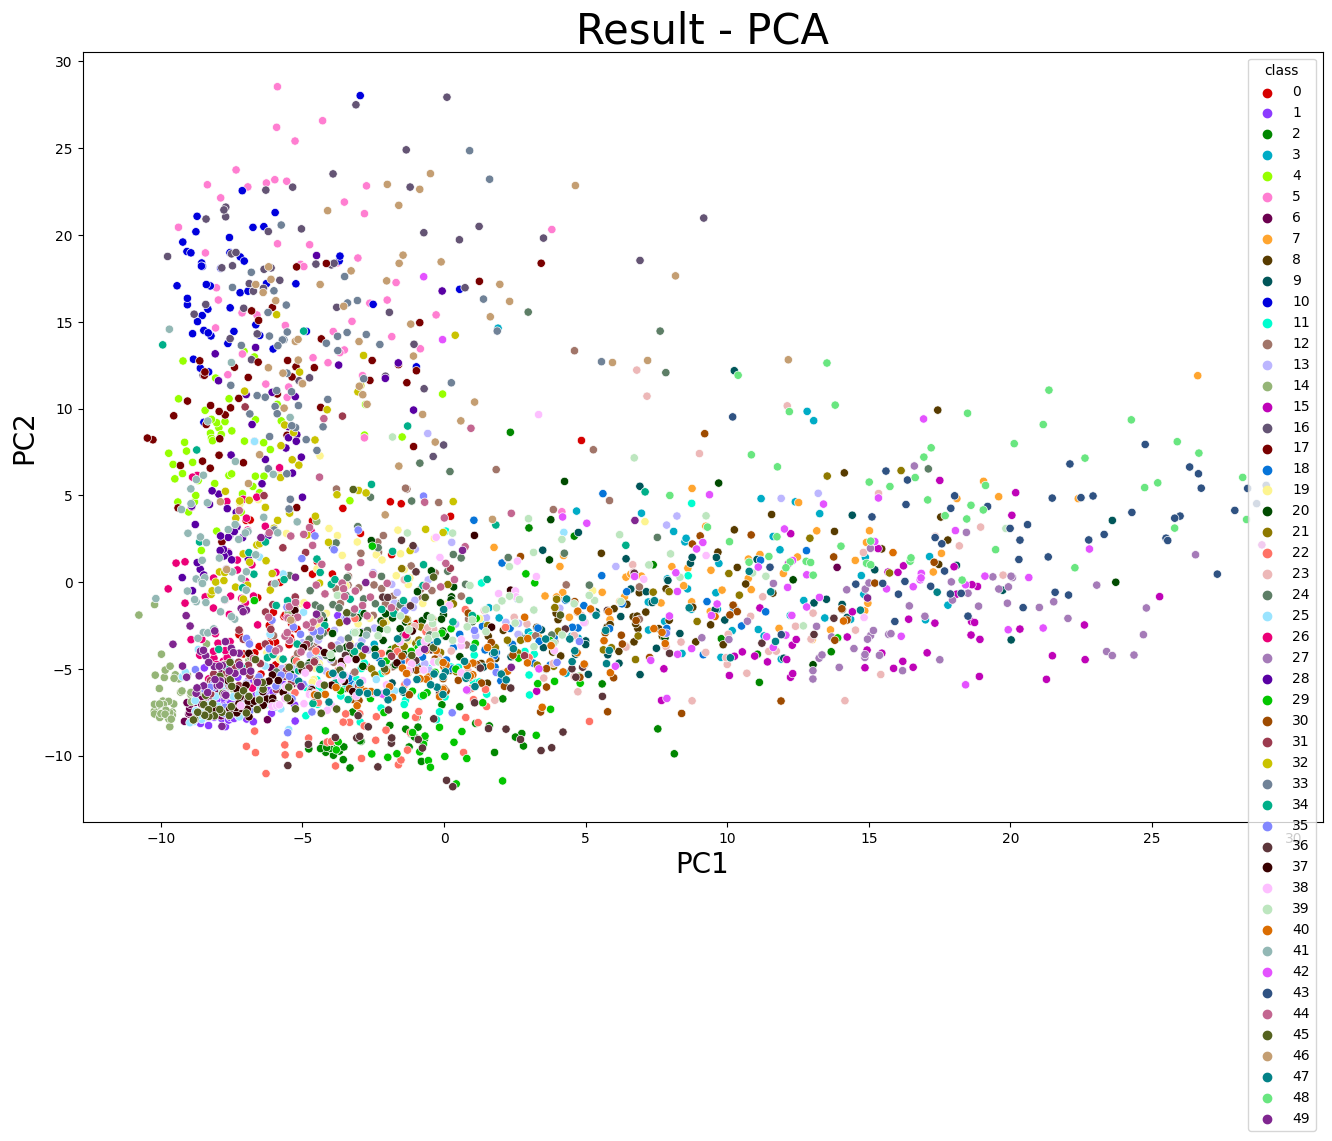

In [50]:
plt.figure(figsize=(16,10))
plot = sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="class",
    palette=sns.color_palette(cc.glasbey, n_colors=50),
    data=finalDf,
    legend="full",
    alpha=1
)
plot.axes.set_title("Result - PCA",fontsize=30)
plot.set_xlabel("PC1",fontsize=20)
plot.set_ylabel("PC2",fontsize=20)

### TSNE

In [11]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(out)

/home/guest/r11922a05/anaconda3/envs/DLCV2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/guest/r11922a05/anaconda3/envs/DLCV2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0, 0.5, 'axis-2')

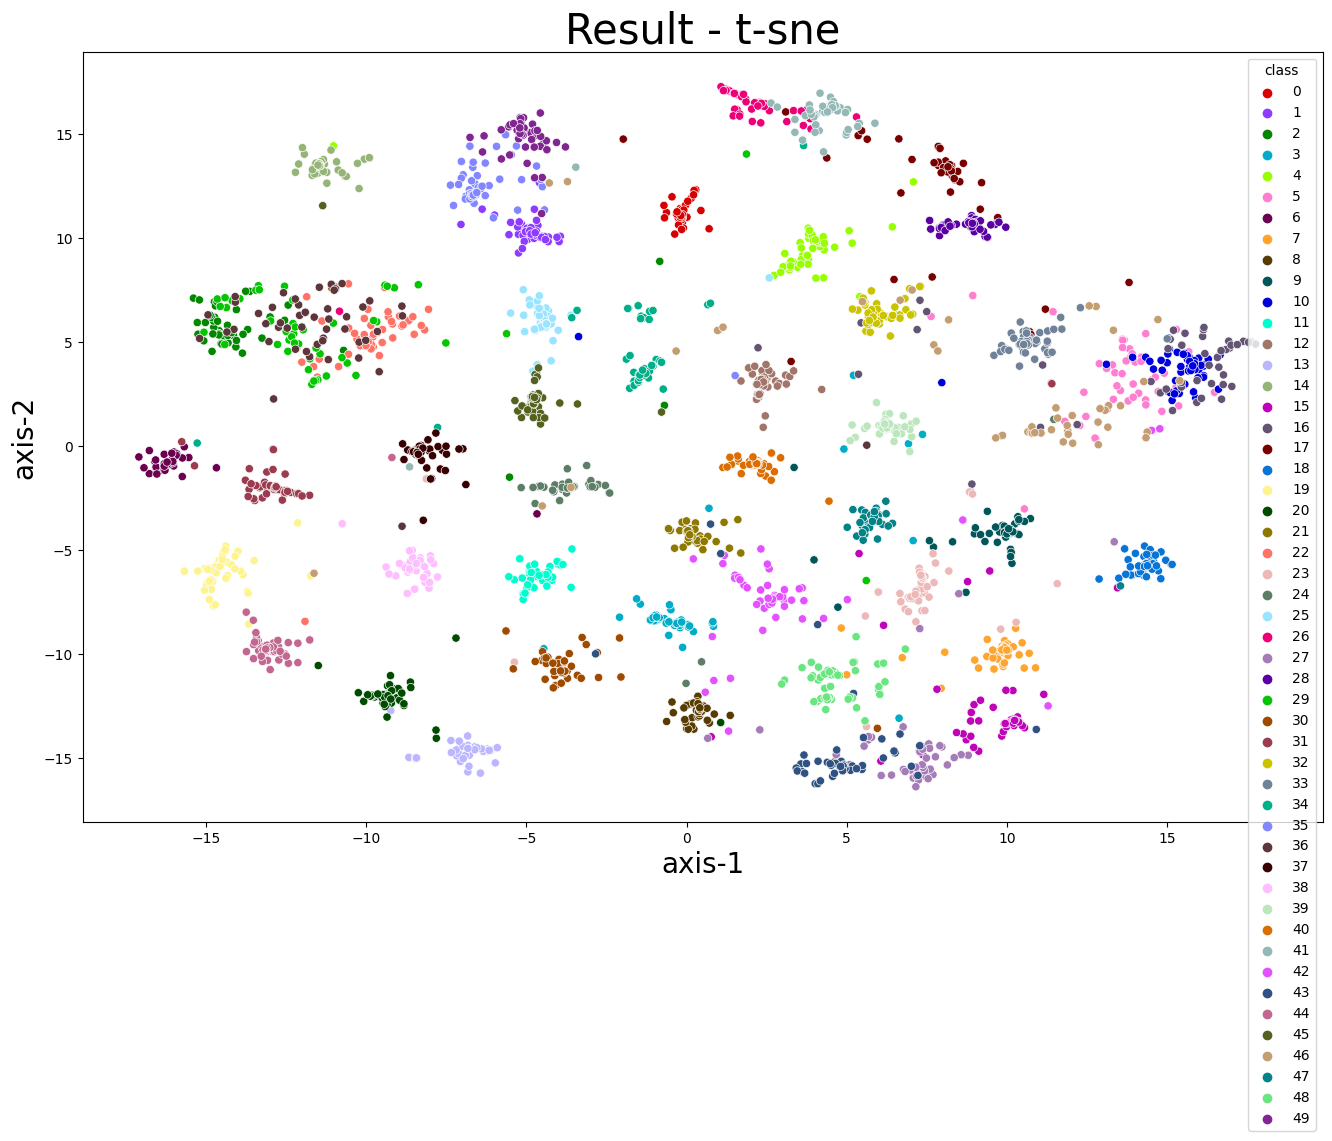

In [52]:
finalDf['tsne-2d-one'] = tsne_results[:,0]
finalDf['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette(cc.glasbey, n_colors=50),
    data=finalDf,
    legend="full",
    alpha=1
)
plot.axes.set_title("Result - t-sne",fontsize=30)
plot.set_xlabel("axis-1",fontsize=20)
plot.set_ylabel("axis-2",fontsize=20)